In [297]:
import keras
import numpy as np
import tensorflow as tf
from keras.datasets import mnist
from matplotlib import pyplot as plt

In [298]:
(x_train, labels_train), (x_test, labels_test) = mnist.load_data()

In [299]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
x_train.shape

(60000, 28, 28)

# Reshape the data to fit the model

In [300]:
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

# One-hot encoding

In [301]:
from keras.utils import to_categorical
y_train = to_categorical(labels_train, 10)
y_test = to_categorical(labels_test, 10)

# Data augmentation

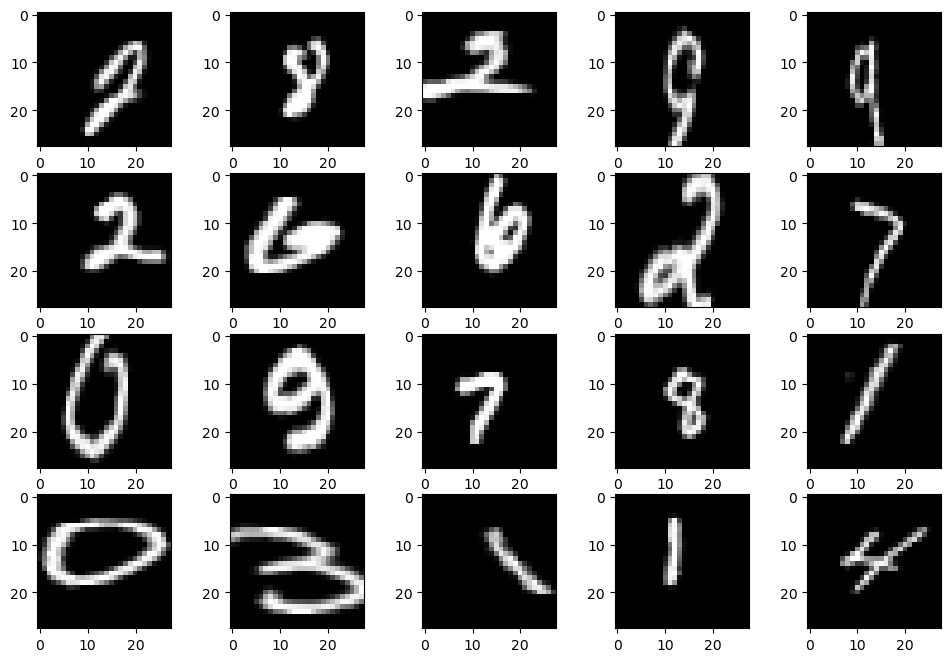

In [302]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20, 
    width_shift_range=0.1, 
    height_shift_range=0.1, 
    zoom_range=0.5,
    shear_range=0.2,
    fill_mode='nearest')

#Plots our figures
pic = datagen.flow(x_train, batch_size=1024)
plt.figure(figsize=(12,8))
for i in range(1,21):
  plt.subplot(4, 5, i)
  batch = pic.next()
  image_ = batch[0].astype('float32')
  plt.imshow(image_, cmap='gray')
plt.show()

# Define the CNN model

In [303]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization, Dropout

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Conv2D(512, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy'])

model.summary()

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_82 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 conv2d_83 (Conv2D)          (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d_59 (MaxPoolin  (None, 12, 12, 64)       0         
 g2D)                                                            
                                                                 
 batch_normalization_80 (Bat  (None, 12, 12, 64)       256       
 chNormalization)                                                
                                                                 
 conv2d_84 (Conv2D)          (None, 10, 10, 128)       73856     
                                                                 
 conv2d_85 (Conv2D)          (None, 8, 8, 256)       

# K-fold cross-validation

In [304]:
# Train and evaluate the model with k-fold cross-validation
from sklearn.model_selection import KFold
from keras.callbacks import EarlyStopping

historys = []

batch_size = 2048
epochs = 20
n_splits = 5

kfold = KFold(n_splits=n_splits, shuffle=True)

for fold, (train_indices, val_indices) in enumerate(kfold.split(x_train)):
    print('Fold:', fold+1)
    x_train_fold = x_train[train_indices]
    y_train_fold = y_train[train_indices]
    x_val_fold = x_train[val_indices]
    y_val_fold = y_train[val_indices]
    
    # Fit the model with data augmentation
    history = model.fit(datagen.flow(x_train_fold, y_train_fold, batch_size=batch_size),
                        epochs=epochs,
                        validation_data=(x_val_fold, y_val_fold),
                        callbacks=[EarlyStopping(patience=5)])
    
    historys.append(history)

Fold: 1
Epoch 1/20


2023-02-20 16:27:37.091528: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


24/24 [==============================] - ETA: 0s - loss: 1.0733 - accuracy: 0.6618

2023-02-20 16:27:45.080690: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


24/24 [==============================] - 13s 487ms/step - loss: 1.0733 - accuracy: 0.6618 - val_loss: 2.2506 - val_accuracy: 0.0984
Epoch 2/20
24/24 [==============================] - 11s 446ms/step - loss: 0.3334 - accuracy: 0.9000 - val_loss: 2.2902 - val_accuracy: 0.1892
Epoch 3/20
24/24 [==============================] - 10s 434ms/step - loss: 0.2149 - accuracy: 0.9370 - val_loss: 2.3898 - val_accuracy: 0.1904
Epoch 4/20
24/24 [==============================] - 10s 432ms/step - loss: 0.1791 - accuracy: 0.9455 - val_loss: 2.3772 - val_accuracy: 0.0963
Epoch 5/20
24/24 [==============================] - 11s 441ms/step - loss: 0.1542 - accuracy: 0.9544 - val_loss: 2.3163 - val_accuracy: 0.0950
Epoch 6/20
24/24 [==============================] - 10s 435ms/step - loss: 0.1309 - accuracy: 0.9615 - val_loss: 2.3401 - val_accuracy: 0.0950
Fold: 2
Epoch 1/20
24/24 [==============================] - 11s 445ms/step - loss: 0.1135 - accuracy: 0.9664 - val_loss: 2.4516 - val_accuracy: 0.0957
Ep

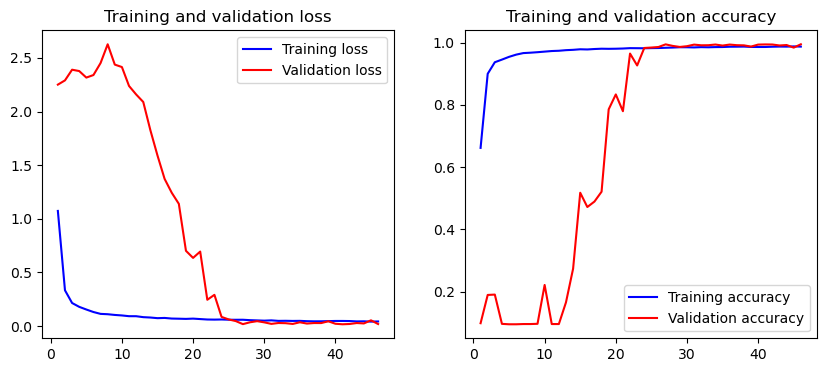

In [305]:
losses = [loss for history in historys for loss in history.history['loss']]
val_losses = [val_loss for history in historys for val_loss in history.history['val_loss']]
accuracies = [accuracy for history in historys for accuracy in history.history['accuracy']]
val_accuracies = [val_accuracy for history in historys for val_accuracy in history.history['val_accuracy']]

epochs = range(1, len(losses) + 1)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, losses, 'b', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, accuracies, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.show()
    

In [306]:
model.save("network_for_mnist.h5")